# Packages

In [ ]:
!pip install -q finance-datareader

In [ ]:
import os
import time

import pandas as pd
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy 
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/Images'

Mounted at /content/gdrive


# Funcation and Class For DATA

In [ ]:
def get_data(sym):
    file_path = "/content/gdrive/MyDrive/stockData/"
    csv_path = os.path.join(file_path, f"{sym}.csv")
    df = pd.read_csv(csv_path, parse_dates=True, index_col = ['Date'])
    return df
    
def Min_Max_Scaler(dataframe):
    d_min = np.min(dataframe, 0)
    d_max = np.max(dataframe, 0)

    numerator = dataframe - d_min
    denominator = d_max - d_min

    df = numerator / (denominator + 1e-7)
    return df   

def return_data(data, data_min, data_max):
    return data * (data_max - data_min) + data_min

In [ ]:
class StockDataset(Dataset):
    
    def __init__(self, data, x_frames, y_frames, start, end):
        self.x_frames = x_frames
        self.y_frames = y_frames

        self.start = start
        self.end = end

        self.data = data.loc[self.start : self.end]


    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['Close','Open', 'High', 'Low', 'Volume', 'Change']]
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

# LSTM Model

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

# EarlyStopping

In [ ]:
class EarlyStopping:
    def __init__(self, args):
        self.patience = args.patience
        self.counter = 0
        self.best_score = None
        self.best_val_acc = None
        self.best_train_acc = None
        self.val_loss_min = np.Inf
        self.early_stop = False


        # self.hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

        if not os.path.isdir(args.path):
            os.mkdir(args.path)

    def __call__(self, val_loss, val_acc, train_acc, model, optimizer):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_val_acc = val_acc
            self.best_train_acc = train_acc
            
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.val_loss_min, val_loss))

            # torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')

            torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
            }, args.path+'forall-model.pt')

            self.val_loss_min = val_loss

        elif score > self.best_score:
            self.counter += 1
            print("EarlyStopping counter: {} out of {}".format(self.counter, self.patience))

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_val_acc = val_acc
            self.best_train_acc = train_acc

            self.counter = 0

            print('Validation loss decreased --- Saving model ...')

            # torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')

            torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
            },args.path+'forall-model.pt')

            self.val_loss_min = val_loss

In [179]:
class EarlyStopping2:
    def __init__(self, args):
        self.patience = args.patience
        self.counter = 0
        self.best_score = None
        self.best_val_acc = None
        self.best_train_acc = None
        self.val_loss_min = np.Inf
        self.early_stop = False


        # self.hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

        if not os.path.isdir(args.path):
            os.mkdir(args.path)

    def __call__(self, val_loss, val_acc, train_acc, model, optimizer):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_val_acc = val_acc
            self.best_train_acc = train_acc
            
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.val_loss_min, val_loss))

            # torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')

            torch.save({
                        'model3_state_dict': model.state_dict(),
                        'optimizer3_state_dict': optimizer.state_dict(),
            }, args.path+'model3.pt')

            self.val_loss_min = val_loss

        elif score > self.best_score:
            self.counter += 1
            print("EarlyStopping counter: {} out of {}".format(self.counter, self.patience))

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_val_acc = val_acc
            self.best_train_acc = train_acc

            self.counter = 0

            print('Validation loss decreased --- Saving model ...')

            # torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')

            torch.save({
                        'model3_state_dict': model.state_dict(),
                        'optimizer3_state_dict': optimizer.state_dict(),
            },args.path+'model3.pt')

            self.val_loss_min = val_loss

# Metirc, Train, Valid, Teset and Experiment Function

In [ ]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)

    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.to(args.device)
        y = y.to(args.device)

        X = X.transpose(0, 1).float()
        y_true = y[:, :, 0].float()
        
        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]


        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / (len(trainloader) + 1e-7)
    train_acc = train_acc / (len(trainloader) + 1e-7)
    return model, train_loss, train_acc

def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            X = X.to(args.device)
            y = y.to(args.device)

            X = X.transpose(0, 1).float()
            y_true = y[:, :, 0].float()

            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
    
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / (len(valloader) + 1e-7)
    val_acc = val_acc / (len(valloader) + 1e-7)
    return val_loss, val_acc

In [ ]:
def test(model, data, start, end, args):
    data_scaled = Min_Max_Scaler(data)

    testset = StockDataset(data_scaled, args.x_frames, args.y_frames, start, end)

    testloader = DataLoader(testset, 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    
    test_t = data.loc[start:end]
    test_ind = test_t.index
    
    d_min = np.min(data, 0)
    d_max = np.max(data, 0)

    model.to(args.device)
    model.eval()    

    test_acc = 0.0
    prediction = []
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X = X.to(args.device)
            y = y.to(args.device)

            X = X.transpose(0, 1).float()
            y_true = y[:, :, 0].float()
            
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

            temp = []
            y = y_pred.cpu().detach().numpy()

            for i in range(len(y)):
                temp.append(y[i].item())

            prediction = prediction + temp


    test_acc = test_acc / (len(testloader) + 1e-7)

    len_pred = len(prediction)
    len_ind = len(test_ind)

    temp_ind = len_pred - len_ind
    ind = test_ind[:temp_ind]

    true_y = data.loc[ind[0]:ind[-1]]['Close']
    true_y = pd.DataFrame(true_y)

    test_df = pd.DataFrame({"Close": prediction}, index=ind)

    acc = mean_absolute_error(Min_Max_Scaler(true_y), test_df) * 100
    test_df = return_data(test_df, d_min[0], d_max[0])


    return test_df, true_y, acc

In [ ]:
def experiment(partition, args, load = False):
    # hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice. Choose one of SGD, RMSprop, Adam')

    if load:
        model, optimizer = load_model(args)
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()
        



    model.to(args.device)

    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
    
    early_stopping = EarlyStopping(args)

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        
        start = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        end = time.time()

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch+1, train_acc, val_acc, train_loss, val_loss, end-start))

        early_stopping(val_loss, val_acc, train_acc, model, optimizer)

        if early_stopping.early_stop:
            print("Early Stopping!!")
            val_loss = early_stopping.val_loss_min
            val_acc = early_stopping.best_val_acc
            train_acc = early_stopping.best_train_acc
            end = time.time()
            break
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #


    model, _ = load_model(args)
    

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = [x for x in train_losses]
    result['val_losses'] = [x for x in val_losses]
    result['train_accs'] = [x for x in train_accs]
    result['val_accs'] = [x for x in val_accs]
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    
    return model, vars(args), result

In [165]:
def experiment2(partition, args, load = False):
    # hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice. Choose one of SGD, RMSprop, Adam')

    if load:
        model, optimizer = load_model2(args)
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()
        



    model.to(args.device)

    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
    
    early_stopping = EarlyStopping2(args)

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        
        start = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        end = time.time()

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch+1, train_acc, val_acc, train_loss, val_loss, end-start))

        early_stopping(val_loss, val_acc, train_acc, model, optimizer)

        if early_stopping.early_stop:
            print("Early Stopping!!")
            val_loss = early_stopping.val_loss_min
            val_acc = early_stopping.best_val_acc
            train_acc = early_stopping.best_train_acc
            end = time.time()
            break
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #


    model, _ = load_model2(args)
    

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = [x for x in train_losses]
    result['val_losses'] = [x for x in val_losses]
    result['train_accs'] = [x for x in train_accs]
    result['val_accs'] = [x for x in val_accs]
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    
    return model, vars(args), result

# Load the trained Model and Result

In [ ]:
def load_model(args):
    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)

    checkpoint = torch.load(args.path+'forall-model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


    return model, optimizer

In [164]:
def load_model2(args):
    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)

    checkpoint = torch.load(args.path+'model2.pt')
    model.load_state_dict(checkpoint['model2_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer2_state_dict'])


    return model, optimizer

In [ ]:
import hashlib
import json
from os import listdir
from os.path import isfile, join


def save_exp_result(setting, result):
    exp_name = setting['exp_name']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    
    filepath = '/content/gdrive/MyDrive/results'
    if not os.path.isdir(filepath):
        os.mkdir(filepath)

    filename = '/content/gdrive/MyDrive/results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = '/content/gdrive/MyDrive/results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)
    return df

# Parser ---> control Parameters

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(args.device)

cuda:0


In [ ]:
args.batch_size = 64
args.x_frames = 5
args.y_frames = 1

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 1

# ====== Regularization ======= #
args.l2 = 0.0001
args.dropout = 0.3
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 100
args.patience = 10
args.path = '/content/gdrive/MyDrive/model_checkpoint/'

# For Training

In [ ]:
sp500 = fdr.StockListing('S&P500')
sp500_list = list(sp500['Symbol'])

args.symbol = sp500_list[0]
df = get_data(args.symbol)
df_scaled = Min_Max_Scaler(df)

split = int(len(df) * 0.8)
split2 = int(len(df) * 0.1)

train_start = df.index[0]
train_end = df.index[split]

val_start = df.index[split]
val_end = df.index[split+split2]

trainset = StockDataset(df_scaled, args.x_frames, args.y_frames, train_start, train_end)
valset = StockDataset(df_scaled, args.x_frames, args.y_frames, val_start, val_end)

partition = {'train': trainset, 'val':valset}
model, setting, result = experiment(partition, deepcopy(args))

error_idx = 0

for name in sp500_list[1:]:
    print(name+' training start')
    args.symbol = name
    df = get_data(args.symbol)
    df_scaled = Min_Max_Scaler(df)

    split = int(len(df) * 0.8)
    split2 = int(len(df) * 0.1)

    train_start = df.index[0]
    train_end = df.index[split]

    val_start = df.index[split]
    val_end = df.index[split+split2]

    trainset = StockDataset(df_scaled, args.x_frames, args.y_frames, train_start, train_end)
    valset = StockDataset(df_scaled, args.x_frames, args.y_frames, val_start, val_end)

    partition = {'train': trainset, 'val':valset}

    model, setting, result = experiment(partition, deepcopy(args), load = True)
    error_idx+=1

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Validation loss decreased (inf --> 0.0010).  Saving model ...
Epoch 2, Acc(train/val): 4.37/1.44, Loss(train/val) 0.00120/0.00010. Took 4.21 sec
Validation loss decreased --- Saving model ...
Epoch 3, Acc(train/val): 3.78/1.42, Loss(train/val) 0.00094/0.00009. Took 4.23 sec
Validation loss decreased --- Saving model ...
Epoch 4, Acc(train/val): 3.86/1.56, Loss(train/val) 0.00101/0.00011. Took 4.22 sec
EarlyStopping counter: 1 out of 10
Epoch 5, Acc(train/val): 3.98/2.55, Loss(train/val) 0.00106/0.00025. Took 4.19 sec
EarlyStopping counter: 2 out of 10
Epoch 6, Acc(train/val): 3.76/2.00, Loss(train/val) 0.00094/0.00017. Took 4.17 sec
EarlyStopping counter: 3 out of 10
Epoch 7, Acc(train/val): 3.76/1.31, Loss(train/val) 0.00091/0.00008. Took 4.16 sec
Validation loss decreased --- Saving model ...
Epoch 8, Acc(train/val): 3.46/1.30, Loss(train/val) 0.00080/0.00008. Took 4.16 sec
Validation loss decreased --- Saving model ...
Epoch 9, Acc(train/val): 3.2

# Load model and Test

In [ ]:
def plot_test(test_y, true_y, name, acc):
    plt.figure(figsize=(10,10))
    plt.title(f"Prediction VS Real --- {name} --- Test Acc: {acc:.2f}")
    plt.plot(test_y, color='b')
    plt.plot(true_y, color='r')
    plt.legend(["Prediction", "True"],loc='upper left')
    plt.show()
    # plt.savefig(f'/content/gdrive/MyDrive/Images/{name}_acc_{acc:.2f}.png', dpi=300)
    plt.clf()

In [185]:
model, _ = load_model(args)

#### Example

In [ ]:
args.symbol = 'IT'
df = get_data(args.symbol)

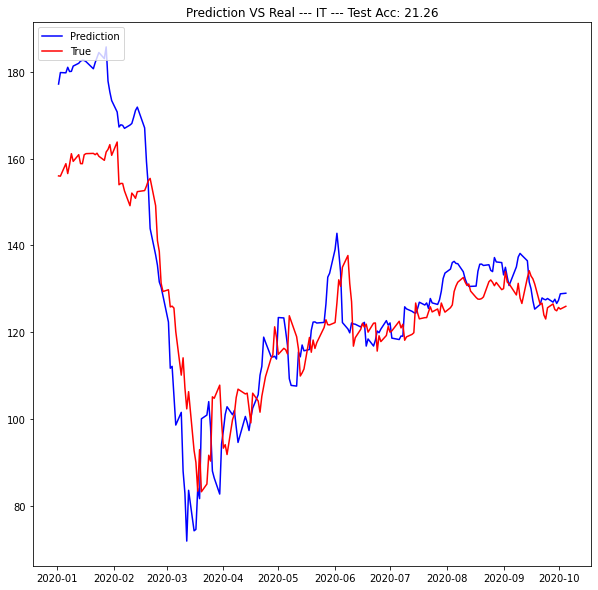

<Figure size 432x288 with 0 Axes>

In [ ]:
test_y, true_y, acc = test(model, df, '2020-01-01', '2020-12-24', args)
plot_test(test_y, true_y, args.symbol, acc)

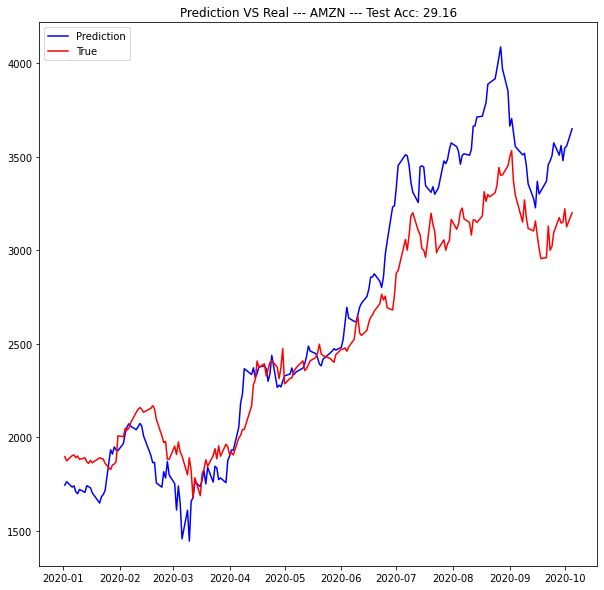

<Figure size 432x288 with 0 Axes>

In [ ]:
args.symbol = 'AMZN'
df2 = get_data(args.symbol)
test_y2, true_y2, acc2 = test(model, df2, '2020-01-01', '2020-12-24', args)
plot_test(test_y2, true_y2, args.symbol, acc2)

# Test All the DATA

In [ ]:
def plot_test(test_y, true_y, name, acc):
    plt.figure(figsize=(10,10))
    plt.title(f"Prediction VS Real --- {name} --- Test Acc: {acc:.2f}")
    plt.plot(test_y, color='b')
    plt.plot(true_y, color='r')
    plt.legend(["Prediction", "True"],loc='upper left')
    # plt.show()
    plt.savefig(f'/content/gdrive/MyDrive/Images/{name}_acc_{acc:.2f}.png', dpi=300)
    plt.clf()

#### Testing

In [32]:
acc_list = []
acc_dict = {}

sp500 = fdr.StockListing('S&P500')
sp500_list = list(sp500['Symbol'])

for name in sp500_list[:235]:
    print(name+' testing start')
    args.symbol = name
    df = get_data(args.symbol)
    df_scaled = Min_Max_Scaler(df)

    split = int(len(df) * 0.1)

    start = df.index[-split]
    end = df.index[-1]

    if len(df.loc[start:end]) < args.batch_size:
        start = "2020-01-01"
        end = "2020-12-24" 

    test_y, true_y, acc = test(model, df, start, end, args)
    acc_list.append(acc)
    acc_dict[name] = acc
    # plot_test(test_y, true_y, name, acc)

for name in sp500_list[236:474]:
    print(name+' testing start')
    args.symbol = name
    df = get_data(args.symbol)
    df_scaled = Min_Max_Scaler(df)

    split = int(len(df) * 0.1)

    start = df.index[-split]
    end = df.index[-1]

    if len(df.loc[start:end]) < args.batch_size:
        start = "2020-01-01"
        end = "2020-12-24" 

    test_y, true_y, acc = test(model, df, start, end, args)
    acc_list.append(acc)
    acc_dict[name] = acc
    # plot_test(test_y, true_y, name, acc)

for name in sp500_list[475:]:
    print(name+' testing start')
    args.symbol = name
    df = get_data(args.symbol)
    df_scaled = Min_Max_Scaler(df)

    split = int(len(df) * 0.1)

    start = df.index[-split]
    end = df.index[-1]

    if len(df.loc[start:end]) < args.batch_size:
        start = "2020-01-01"
        end = "2020-12-24" 

    test_y, true_y, acc = test(model, df, start, end, args)
    acc_list.append(acc)
    acc_dict[name] = acc
    # plot_test(test_y, true_y, name, acc)

MMM testing start
ABT testing start
ABBV testing start
ABMD testing start
ACN testing start
ATVI testing start
ADBE testing start
AMD testing start
AAP testing start
AES testing start
AFL testing start
A testing start
APD testing start
AKAM testing start
ALK testing start
ALB testing start
ARE testing start
ALXN testing start
ALGN testing start
ALLE testing start
LNT testing start
ALL testing start
GOOGL testing start
GOOG testing start
MO testing start
AMZN testing start
AMCR testing start
AEE testing start
AAL testing start
AEP testing start
AXP testing start
AIG testing start
AMT testing start
AWK testing start
AMP testing start
ABC testing start
AME testing start
AMGN testing start
APH testing start
ADI testing start
ANSS testing start
ANTM testing start
AON testing start
AOS testing start
APA testing start
AAPL testing start
AMAT testing start
APTV testing start
ADM testing start
ANET testing start
AJG testing start
AIZ testing start
T testing start
ATO testing start
ADSK testing 

In [ ]:
filename = '/content/gdrive/MyDrive/results/LSTM-ForAll.json'
with open(filename, 'w') as f:
    json.dump(acc_dict, f)

#### Result

In [39]:
filename = '/content/gdrive/MyDrive/results/LSTM-ForAll.json'

with open(filename, 'r') as f:
    result = json.load(f)

In [113]:
result_df = pd.DataFrame(data = list(result.values()), index = list(result.keys()), columns = ["Accuracy"]) 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


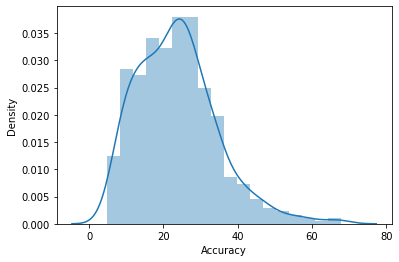

In [128]:
sns.distplot(result_df['Accuracy'])

In [114]:
minValue = result_df.min().item()
maxValue = result_df.max().item()

minName = result_df.idxmin().item()
maxName = result_df.idxmax().item()

meanScore = result_df.mean().item()
std = result_df.std().item()

print(f'Best Prediction: {minName} -- {minValue:.2f}')
print(f"Worst Prediction: {maxName} --{maxValue:.2f}")
print(f"Meam Score: {meanScore:.2f}")

Best Prediction: AMD -- 4.82
Worst Prediction: AIG --67.89
Meam Score: 23.70


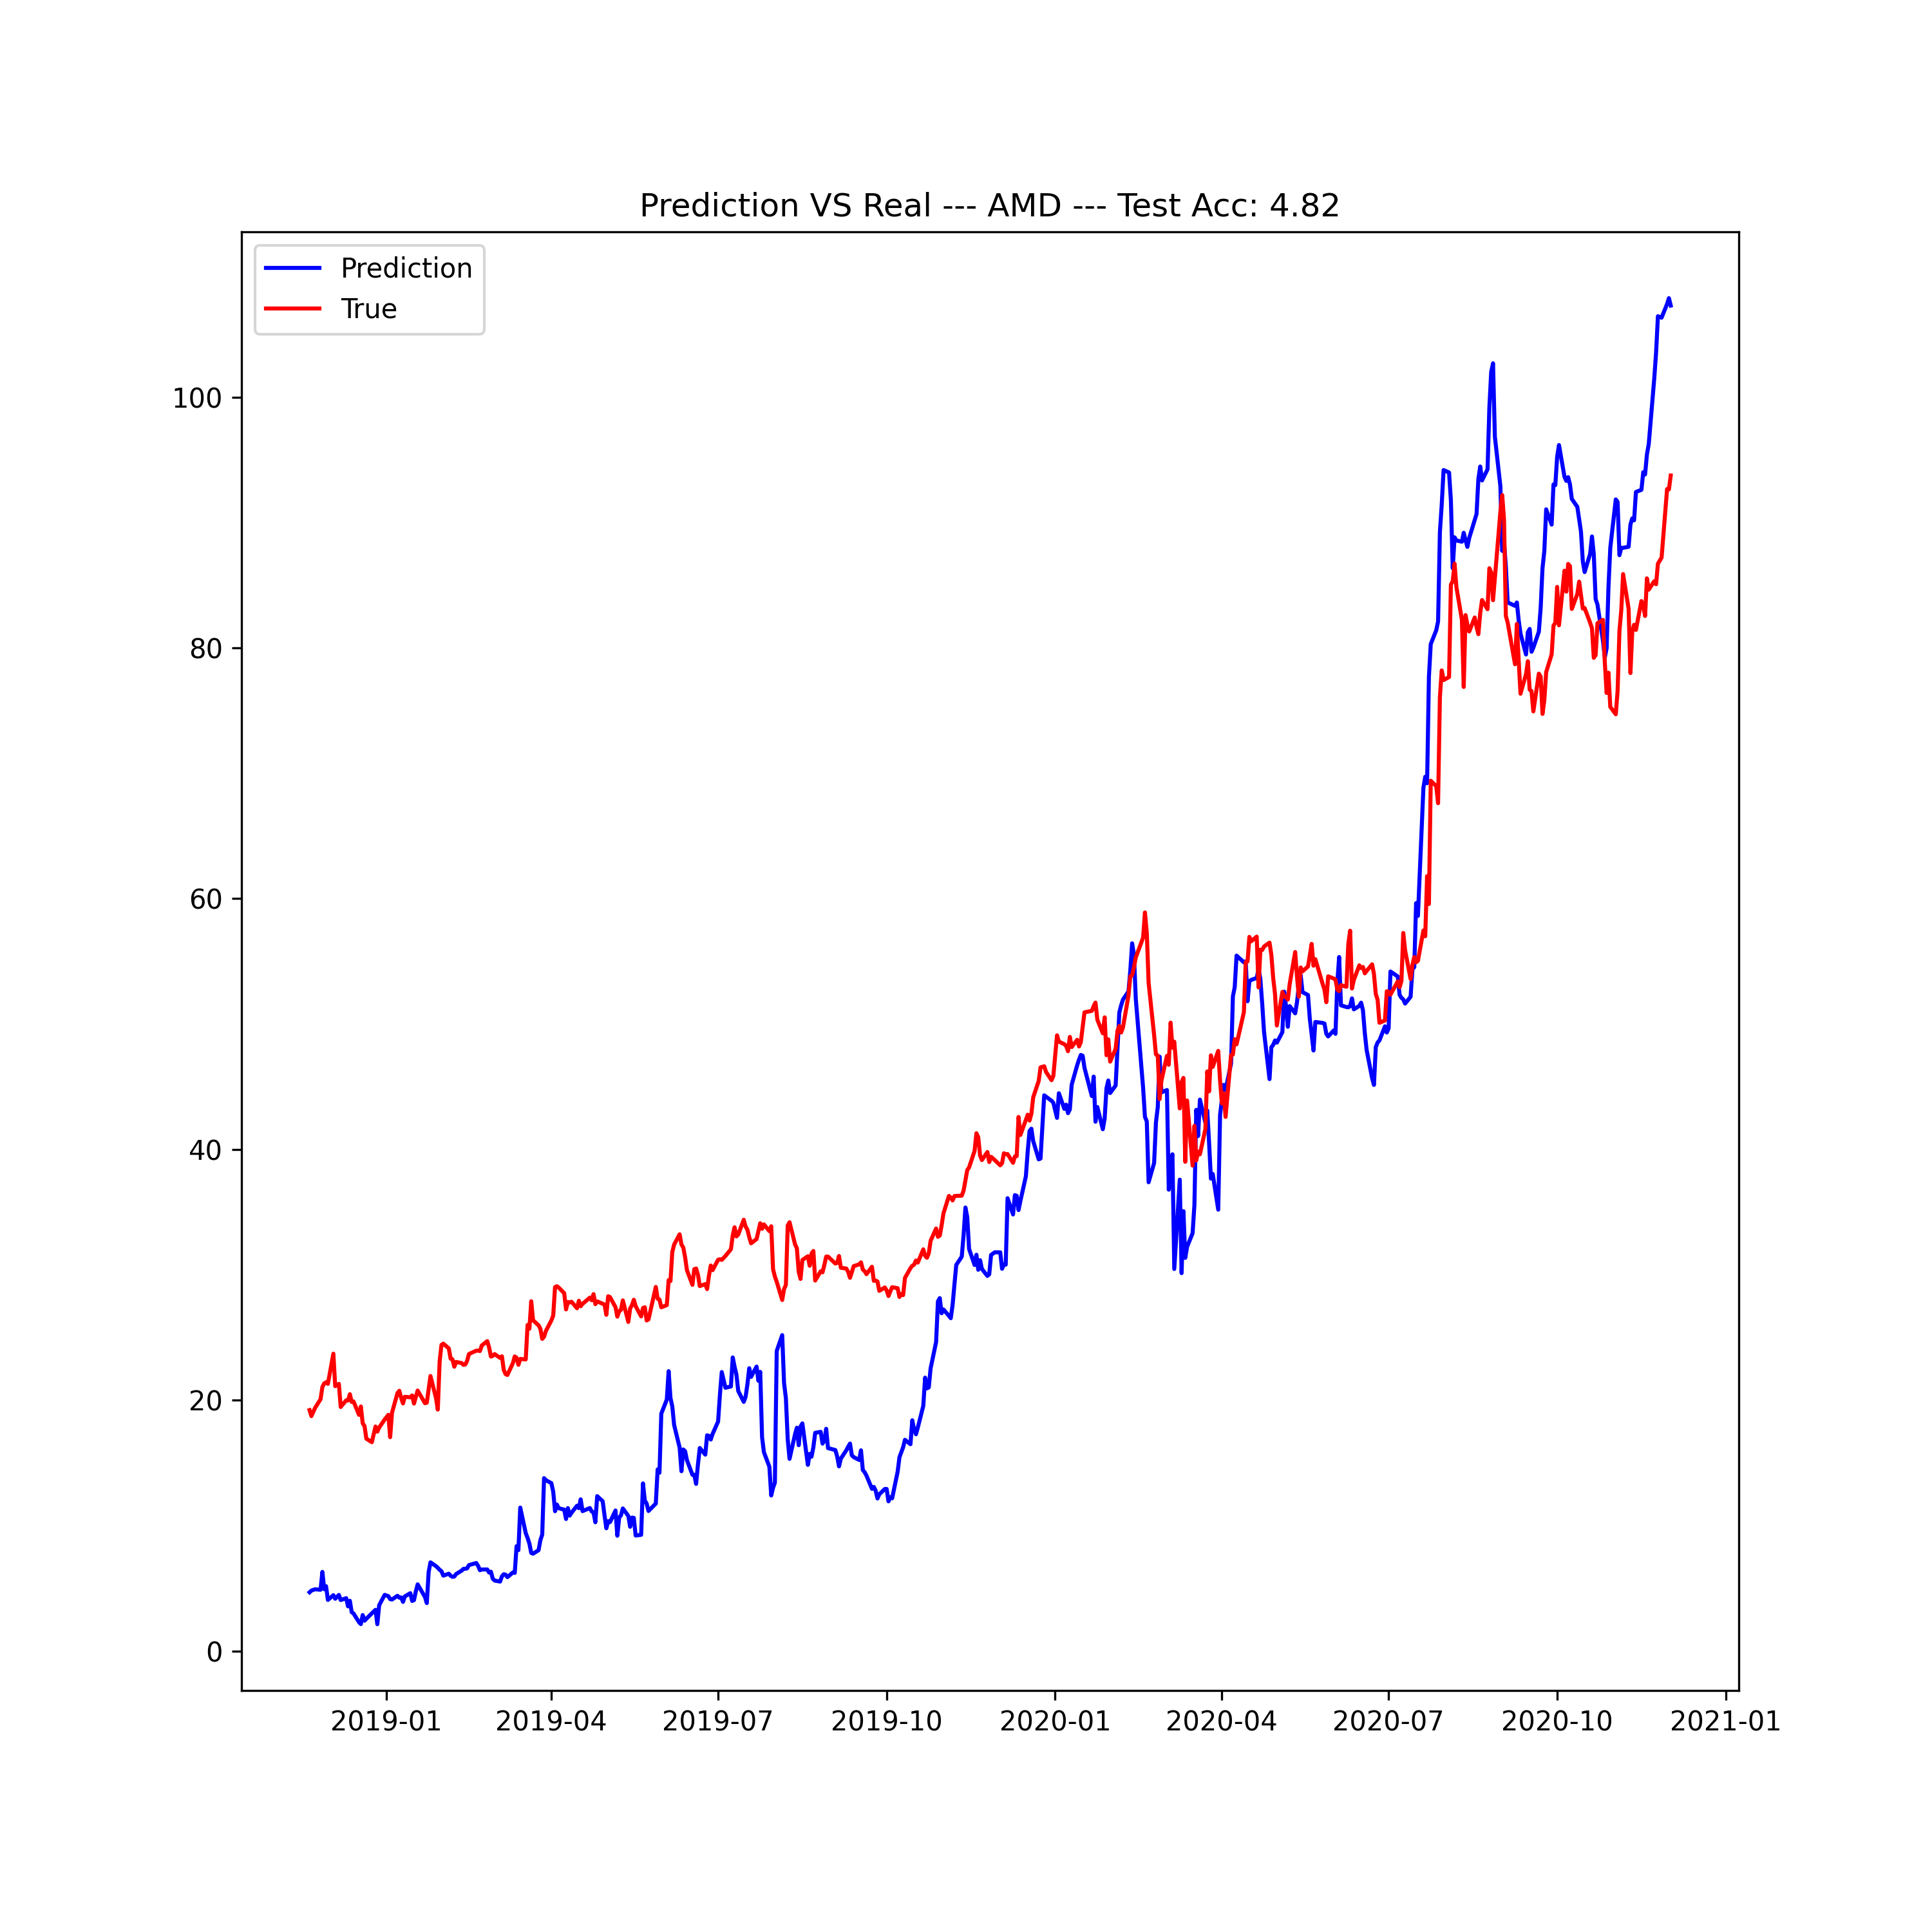

In [136]:
from IPython.display import Image

Image(f'/content/gdrive/MyDrive/Images/{minName}_acc_{minValue:.2f}.png', width=700 , height=700)

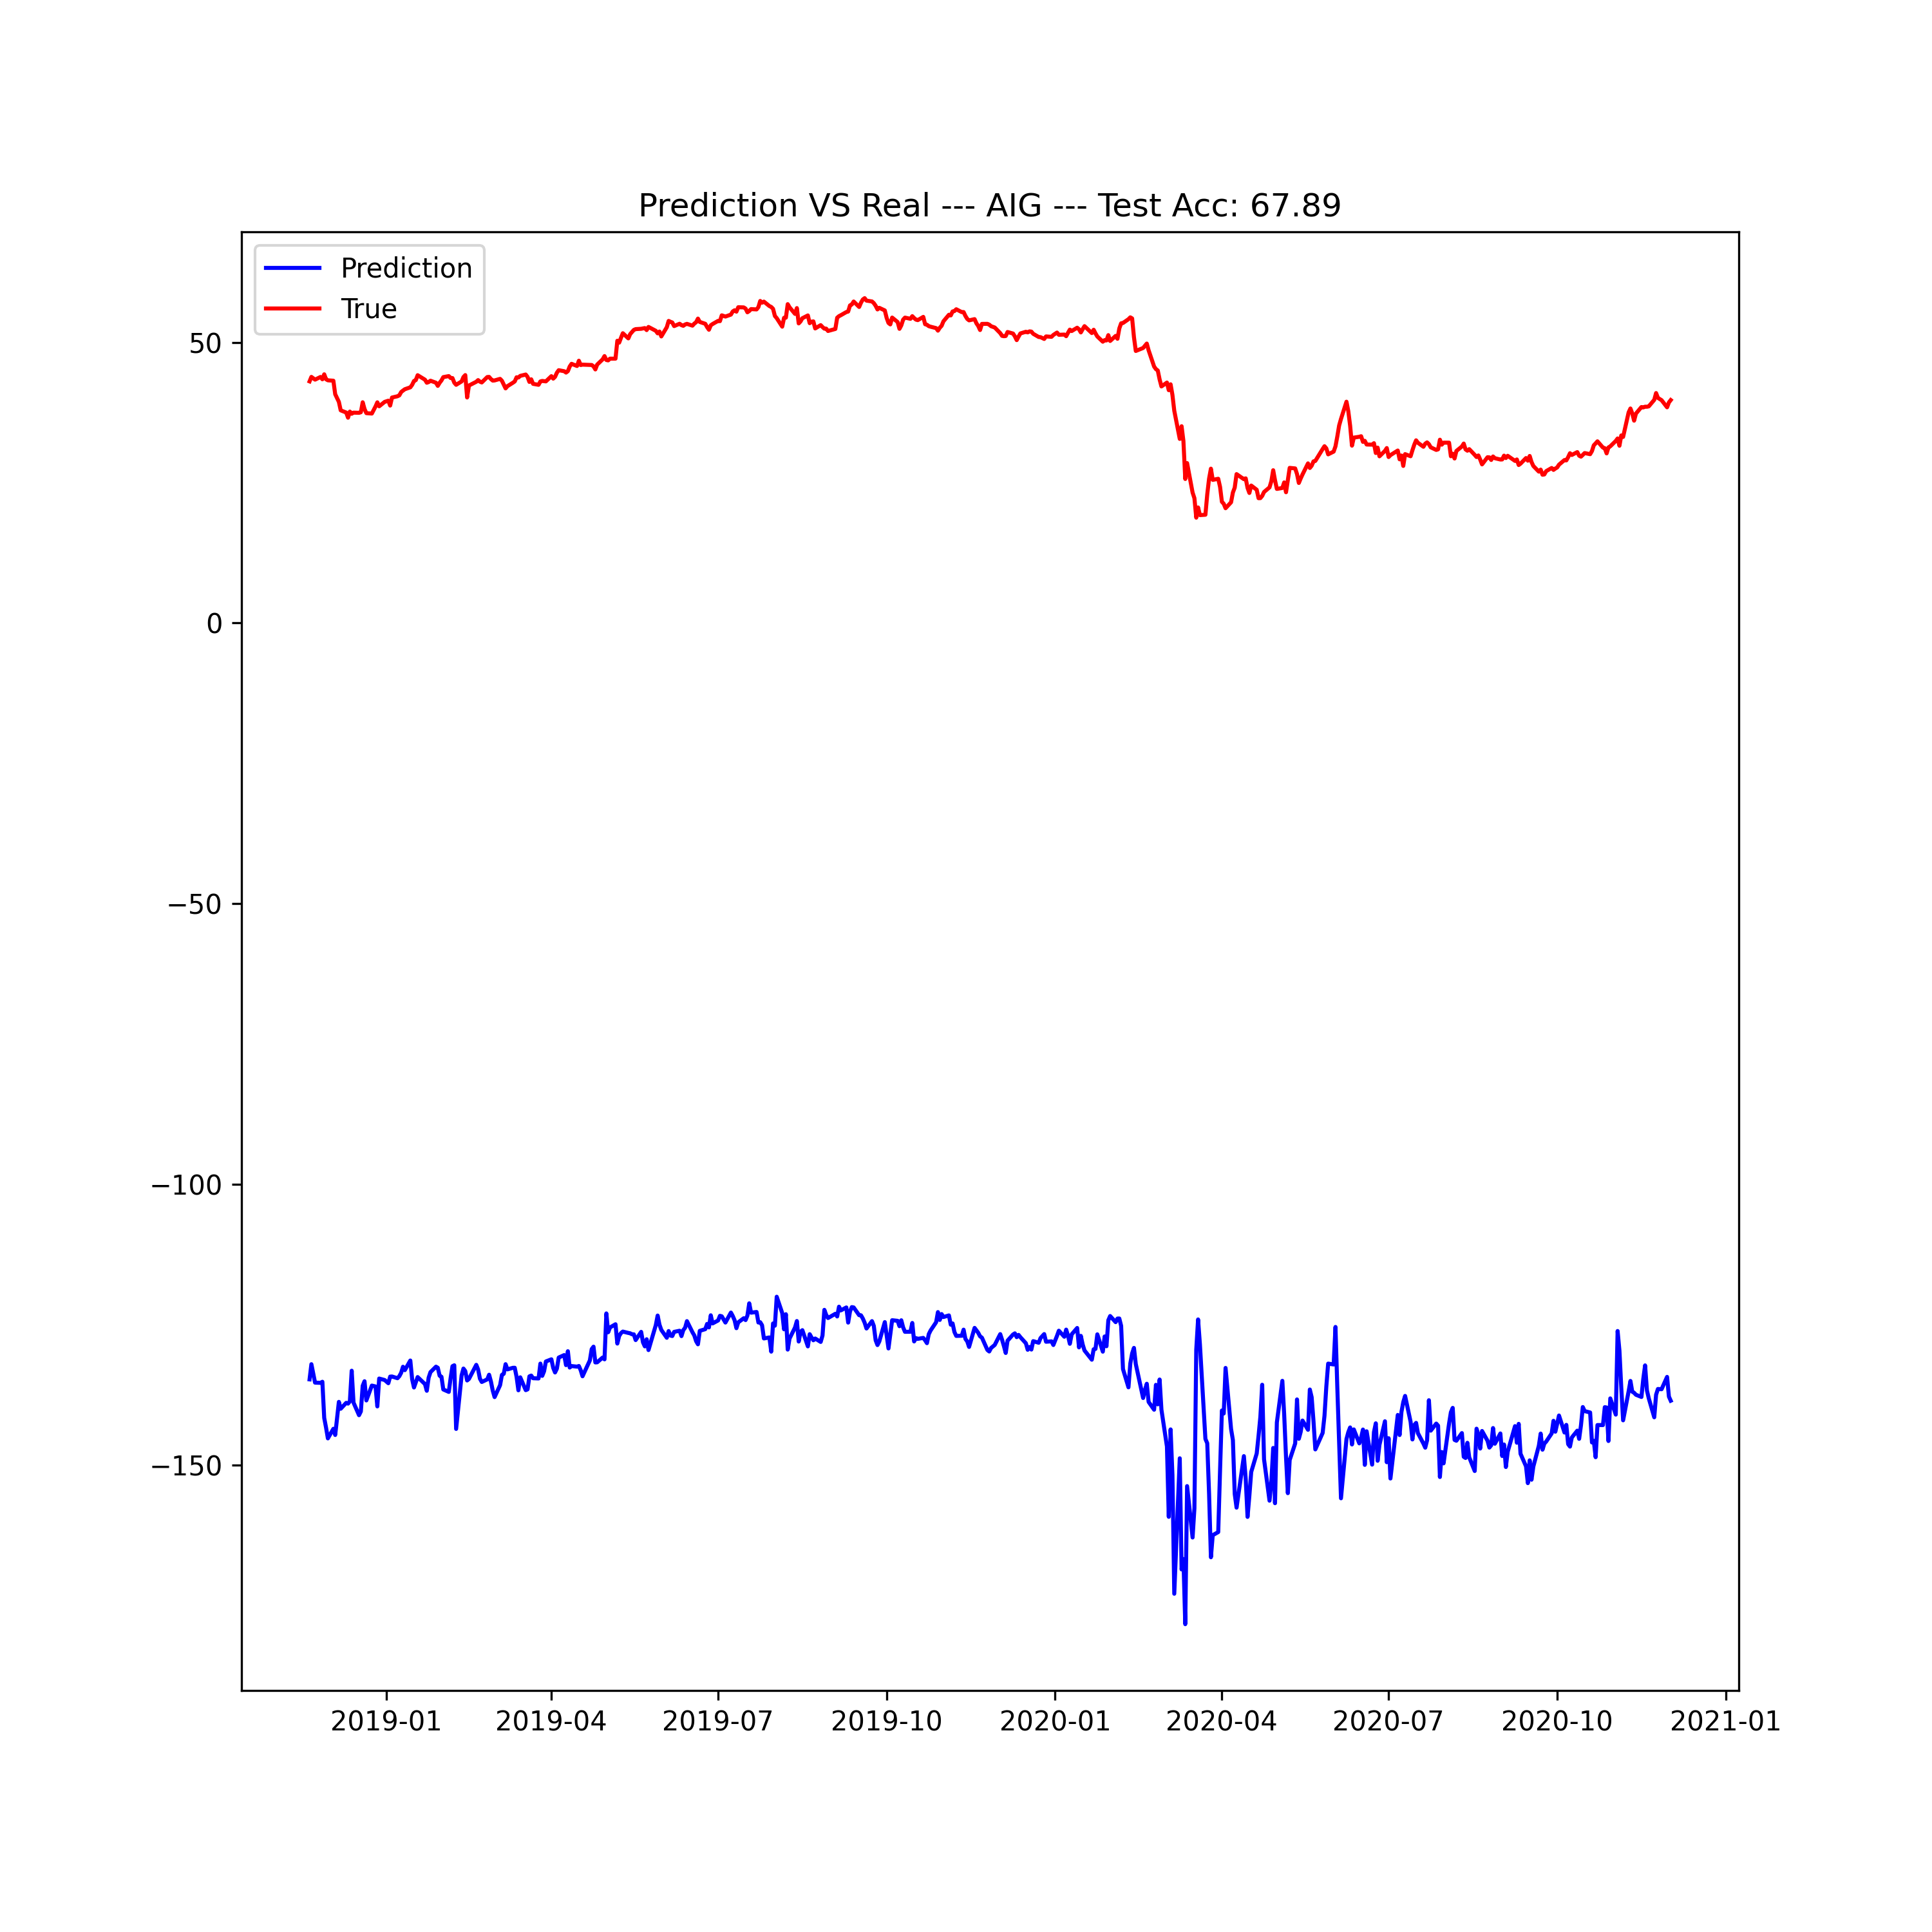

In [137]:
Image(f'/content/gdrive/MyDrive/Images/{maxName}_acc_{maxValue:.2f}.png', width=700 , height=700)

# Retrain

In [162]:
bad_df = result_df[result_df['Accuracy'] > meanScore + std]
bad_index = list(bad_df.index)

In [166]:
args.symbol = bad_index[0]

df = get_data(args.symbol)
df_scaled = Min_Max_Scaler(df)

split = int(len(df) * 0.8)
split2 = int(len(df) * 0.1)

train_start = df.index[0]
train_end = df.index[split]

val_start = df.index[split]
val_end = df.index[split+split2]

trainset = StockDataset(df_scaled, args.x_frames, args.y_frames, train_start, train_end)
valset = StockDataset(df_scaled, args.x_frames, args.y_frames, val_start, val_end)

partition = {'train': trainset, 'val':valset}
model_2, setting, result = experiment2(partition, deepcopy(args))

for name in bad_index[1:]:
    print(name+' training start')
    args.symbol = name
    df = get_data(args.symbol)
    df_scaled = Min_Max_Scaler(df)

    split = int(len(df) * 0.8)
    split2 = int(len(df) * 0.1)

    train_start = df.index[0]
    train_end = df.index[split]

    val_start = df.index[split]
    val_end = df.index[split+split2]

    trainset = StockDataset(df_scaled, args.x_frames, args.y_frames, train_start, train_end)
    valset = StockDataset(df_scaled, args.x_frames, args.y_frames, val_start, val_end)

    partition = {'train': trainset, 'val':valset}

    model_2, setting, result = experiment2(partition, deepcopy(args), load = True)

Epoch 1, Acc(train/val): 21.12/11.44, Loss(train/val) 0.04854/0.01085. Took 3.92 sec
Validation loss decreased (inf --> 0.0109).  Saving model ...
Epoch 2, Acc(train/val): 16.83/3.26, Loss(train/val) 0.02631/0.00141. Took 3.85 sec
Validation loss decreased --- Saving model ...
Epoch 3, Acc(train/val): 15.43/2.28, Loss(train/val) 0.02282/0.00079. Took 3.87 sec
Validation loss decreased --- Saving model ...
Epoch 4, Acc(train/val): 13.29/2.00, Loss(train/val) 0.01749/0.00062. Took 3.88 sec
Validation loss decreased --- Saving model ...
Epoch 5, Acc(train/val): 12.46/2.49, Loss(train/val) 0.01561/0.00067. Took 3.83 sec
EarlyStopping counter: 1 out of 10
Epoch 6, Acc(train/val): 11.22/1.82, Loss(train/val) 0.01313/0.00044. Took 3.84 sec
Validation loss decreased --- Saving model ...
Epoch 7, Acc(train/val): 10.23/1.41, Loss(train/val) 0.01076/0.00031. Took 3.86 sec
Validation loss decreased --- Saving model ...
Epoch 8, Acc(train/val): 9.99/2.91, Loss(train/val) 0.01127/0.00102. Took 3.98 

# Retest

#### RETESTING

In [167]:
model2, _ = load_model2(args)

In [181]:
def plot_test(test_y, true_y, name, acc):
    plt.figure(figsize=(10,10))
    plt.title(f"Prediction VS Real --- {name} --- Test Acc: {acc:.2f}")
    plt.plot(test_y, color='b')
    plt.plot(true_y, color='r')
    plt.legend(["Prediction", "True"],loc='upper left')
    plt.show()
    # plt.savefig(f'/content/gdrive/MyDrive/Images2/{name}_acc_{acc:.2f}.png', dpi=300)
    plt.clf()

In [174]:
acc_list = []
acc_dict = {}

for name in bad_index:
    print(name+' testing start')
    args.symbol = name
    df = get_data(args.symbol)
    df_scaled = Min_Max_Scaler(df)

    split = int(len(df) * 0.1)

    start = df.index[-split]
    end = df.index[-1]

    if len(df.loc[start:end]) < args.batch_size:
        start = "2020-01-01"
        end = "2020-12-24" 

    test_y, true_y, acc = test(model2, df, start, end, args)
    acc_list.append(acc)
    acc_dict[name] = acc 

    plot_test(test_y, true_y, name, acc)

filename = '/content/gdrive/MyDrive/results/retrain_result.json'
with open(filename, 'w') as f:
    json.dump(acc_dict, f)

AES testing start
AKAM testing start
AEE testing start
AEP testing start
AIG testing start
ABC testing start
AMGN testing start
APA testing start
BKR testing start
BDX testing start
CMG testing start
CHD testing start
C testing start
CTXS testing start
CLX testing start
CMS testing start
CL testing start
GLW testing start
DVN testing start
FANG testing start
DLR testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


EXC testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


FIS testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


FITB testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


F testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


FCX testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


GPS testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


GE testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


HPE testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


HRL testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


ICE testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


IPG testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


IVZ testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


JKHY testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


J testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


JNPR testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


KEY testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


KEYS testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


KIM testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


KMI testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


KHC testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


LB testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


LLY testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


LIN testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


LOW testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


LUMN testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


MRO testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


MRK testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


MGM testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


MOS testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


NOV testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


NWSA testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


NWS testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


NLSN testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


NI testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


NCLH testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


PRGO testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


PGR testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


RF testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


RSG testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


SLB testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


STX testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


TROW testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


UA testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


VZ testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


VIAC testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


VNO testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


WMB testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


XEL testing start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

#### ?????

In [175]:
retrain_result_df = pd.DataFrame(data = list(acc_dict.values()), index = list(acc_dict.keys()), columns = ["Accuracy"]) 

In [176]:
minValue = retrain_result_df.min().item()
maxValue = retrain_result_df.max().item()

minName = retrain_result_df.idxmin().item()
maxName = retrain_result_df.idxmax().item()

meanScore = retrain_result_df.mean().item()
std = retrain_result_df.std().item()

print(f'Best Prediction: {minName} -- {minValue:.2f}')
print(f"Worst Prediction: {maxName} --{maxValue:.2f}")
print(f"Meam Score: {meanScore:.2f}")

Best Prediction: LUMN -- 26.27
Worst Prediction: AIG --60.70
Meam Score: 37.07


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


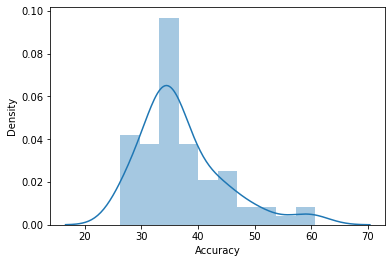

In [177]:
sns.distplot(retrain_result_df['Accuracy'])